In [147]:
# Import 
import csv 
import numpy as np                   
import pandas as pd 

import matplotlib.pyplot as plot
import matplotlib.patches as mpatches

import scipy.stats as stats
from scipy.stats import binom

In [285]:
## load the T-count distribution from Mary. 
## This file contains the summary of all the Ts per read in the aligned data set.
## E.g. 200 reads has 1 T, 345 reads has 2 Ts in them and so forth
TCount_INPUT = 't5MTMMinformed6_withDups_PEfrag_MTall_TcountDistributions.txt'
Frequency_INPUT = 't5MTMMinformed6_withDups_PEfrag_MTall_TCconvFreq.txt'

733453

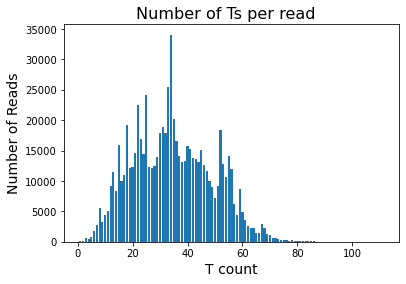

In [287]:
# Define time point you're looking at
TP = 'AriTC0'
## load the T-count distribution from Mary. 
## This file contains the summary of all the Ts per read in the aligned data set.
## E.g. 200 reads has 1 T, 345 reads has 2 Ts in them and so forth
df = pd.read_csv(TCount_INPUT ,sep='\t', header=(0), usecols=['Tcount',TP])

#Plot the T-count distribution for the 0 min library
fig, ax = plot.subplots()
plot.figtext(.5,.9,'Number of Ts per read', fontsize=16, ha='center')
ax.set_ylabel('Number of Reads', fontsize=14)
ax.set_xlabel('T count', fontsize=14)
plot.bar(df['Tcount'],df[TP])

sum(df[TP])

In [288]:
### Here we make the background model of expected TC conversions given the 0min library T count distribution
# and the given conversion rates below

Model = []
# set the granularity of the rates you want to try
num_steps = 4000

# set the starting conversion rate (max conversion rate = lowest_rate * num_step )
lowest_rate = 0.000005

#The first Loop sets the conversion rate we apply to the binomial ditsributions
for step in range (0,num_steps): 
    conver_rate   =  lowest_rate * step
    summary = [0]  
###The Second Loop calculates the binomial distribution for each bin of Tcounts
#Then it multiplies the output with the absolute number of reads in each bin
#Finally it sum all of the successes
    for num_T in range(0,len(df['Tcount'])):    
        # Here we loop over the whole distribution of reads we created above
        n, p = df['Tcount'][num_T], conver_rate
        rv = binom(n, p)
        summary = summary + (df[TP][num_T]* rv.pmf(range(100)))
    Model.append(summary)

In [289]:
## Here we load the file that contains all the MEASURED conversions per read in the aligned data set.
#This is the data we want to find match to the binomial distributions we created above to estimate the conversion rate. 
Freq = pd.read_csv(Frequency_INPUT ,sep='\t', header=(0), usecols=['TCperRead',TP])
Freq

,TCperRead,AriTC0
0,0,719177
1,1,14056
2,2,206
3,3,14
4,4,0
5,5,0


In [291]:
## observed = is the ratio between reads with 0 and 1 TC conversions in the MEASURED (and backgroun corrected) data
observed = Freq[TP][0]/Freq[TP][1]

## a = contain the conversion rates we used above
a = np.arange(0,(lowest_rate*num_steps), lowest_rate)

## b = is the ratio between reads with 0 and 1 TC conversions in the BINOMIAL PDF data
data = pd.DataFrame(Model)
b = data[0]/data[1]

## Here we use the BINOMIAL PDFs to see which one most closely matched the MEASURED data
diff = []
for r in range(1,len(b)):
    diff.append(abs(observed - b[r]))

## Here we extract the conversion rate from the BINOMIAL PDF that most closely matched the MEASURED data
seed_rate = a[diff.index(min(diff))]
seed_rate

0.0005600000000000001

In [292]:
### This script takes the observed distribution of TC conversions in the 0 min timepoint and try to 
# explain that distribution using two distinct fraction of reads with two distinct 
# conversion rates one HIGH and one LOW

rates = [seed_rate]
fractions = []
difference = []

### We start the algorithm with the seed rate we got above
s = seed_rate 

## we set the number of times the algorithm can try to find two stable populations explaining the MEASURED data 
num_tries = 20

for num_tries in range(0,num_tries):
    summary_low = []
    summary_high = []
## first we ask if the rate (s) we're applying is the LOW or HIGH rate
# if the rate is LOW we estimate how many reads we expect to have 2 or 3 TC conversions
# We then subtract that from the Measured number of reads with 2 or 3 conversions
# These residual reads we then use to estimate a second HIGHER conversion rate impacting a smaller subset of reads  
    if s < 0.0008:
# Here we loop over the whole distribution of reads using the conversion rate 's' (which the first time = seed_rate)
        summary = [0]   
        for i in range(0,len(df['Tcount'])):    
            n, p = df['Tcount'][i], s
            rv = binom(n, p)
            summary = summary + (df[TP][i]* rv.pmf(range(100)))

#We store the count numbers from the LOW conversion rate
        One_low = summary[1]
        Two_low = summary[2]        
        Three_low = summary [3]
        
#Get the residual number of reads with 2 or 3 conversions after subtracting 
#the reads counts using the LOW conversion rate 
        ratio_high = (Freq[TP][2]-Two_low) / (Freq[TP][3]-Three_low)

#Estimate new HIGH conversion rate
        b = data[2]/data[3]
        diff = []
        for r in range(1,len(b)):
            diff.append(abs(ratio_high - b[r]))
    
        s = a[diff.index(min(diff))]

# if the rate is HIGH we estimate how many reads we expect to have 2 or 3 TC conversions
# We then subtract that from the Measured number of reads with 2 or 3 conversions
# These residual reads we then use to estimate a second HIGHER conversion rate impacting a smaller subset of reads         
    else:
        summary = [0]   
        for i in range(0,len(df['Tcount'])):    
# Here we loop over the whole distribution of reads using the conversion rate 's' (when s > 0.001 = HIGH)
            n, p = df['Tcount'][i], s
            rv = binom(n, p)
            summary = summary + (df[TP][i]* rv.pmf(range(100)))

#We store the count numbers from the HIGH conversion rate 
        One_high = summary[1]
        Two_high = summary[2]        
        Three_high = summary [3]
        
#Calculate what the subfraction of reads that experience 
#the HIGH rate (= residual reads/if all reads had the high conversion rate)
        frac_high = (Freq[TP][2]-Two_low)/Two_high
        
# Now that we know the subfraction of reads with HIGH conversion rate we
# can calculate what's the number of reads with 1 TC conversions that comes from the reads with HIGH rate
        ones = Freq[TP][1]-(One_high*frac_high)
        
#Correct for the fact that the rate only applies to the LOW subfraction 
        ones = ones*(1-frac_high)
        
#Estimate new LOW conversion rate
        b = data[1]
        diff = []
        for r in range(1,len(b)):
            diff.append(abs(ones - b[r]))
    
        s = a[diff.index(min(diff))]

### Store all the residual values 
        difference.append((Freq[TP][1]-((One_high*frac_high) + (One_low*(1-frac_high))),
                      Freq[TP][2]-((Two_high*frac_high) + (Two_low*(1-frac_high))),
                      Freq[TP][3]-((Three_high*frac_high) + (Three_low*(1-frac_high)))))
### Store all estimates of the size of the subfractions
        fractions.append(frac_high)

### Store all rates estimates o
    rates.append(s)
    
dif = pd.DataFrame(pd.DataFrame(abs(pd.DataFrame(difference)).sum(axis=1).rank()))
Min_Res_Run = pd.DataFrame(dif[dif[0]==1].index)

difference

[(3.589335227125048, 0.10627206274679679, 0.005171602201578196),
 (109.82702318805968, 0.11727046889652115, 0.004630707233657105),
 (109.82702318805968, 0.11727046889652115, 0.004630707233657105),
 (109.82702318805968, 0.11727046889652115, 0.004630707233657105),
 (109.82702318805968, 0.11727046889652115, 0.004630707233657105),
 (109.82702318805968, 0.11727046889652115, 0.004630707233657105),
 (109.82702318805968, 0.11727046889652115, 0.004630707233657105),
 (109.82702318805968, 0.11727046889652115, 0.004630707233657105),
 (109.82702318805968, 0.11727046889652115, 0.004630707233657105),
 (109.82702318805968, 0.11727046889652115, 0.004630707233657105)]

In [293]:
### This is the residual values after subtracting the values from the BPF. 
#These values should match the negative control values in the "Counts"-output below
difference[Min_Res_Run[0][0]]

(3.589335227125048, 0.10627206274679679, 0.005171602201578196)

In [294]:
### This is the background conversion rate that will be applied to the other time points
background_rates = [rates[(Min_Res_Run[0][0]*2)],rates[(Min_Res_Run[0][0]*2)+1]]
background_rates

[0.0005600000000000001, 0.01787]

In [295]:
### This is the fraction of reads impacted by the higher background rate
Fraction_high_rate_reads = fractions[Min_Res_Run[0][0]]
Fraction_high_rate_reads

0.0006901173798380494

In [296]:
### Here we background correct the MEASURED data based on our background conversion rate estimates 
Columns = []
Counts = []
## Get T-count and MEASURED values for time point
df_c = pd.read_csv(TCount_INPUT ,sep='\t',header=(0))
Freq_c = pd.read_csv(Frequency_INPUT ,sep='\t', header=(0))

#Time point to be corrected

for c in range(1,len(pd.DataFrame(df_c).columns)):
    c_TP = pd.DataFrame(df_c).columns[c]
    summary = [0]   
    for i in range(0,len(df_c['Tcount'])):    
        n, p = df_c['Tcount'][i], background_rates[1]
        rv = binom(n, p)
        summary = summary + (df_c[c_TP][i]* rv.pmf(range(100)))
        HIGH_counts = summary*Fraction_high_rate_reads

    summary = [0]   
    for i in range(0,len(df_c['Tcount'])):    
        n, p = df_c['Tcount'][i], background_rates[0]
        rv = binom(n, p)
        summary = summary + (df_c[c_TP][i]* rv.pmf(range(100)))
        LOW_counts = summary*(1-Fraction_high_rate_reads)

    Columns.append(c_TP)
    Counts.append((Freq_c[c_TP][1]-(HIGH_counts + LOW_counts)[1],Freq_c[c_TP][2]-(HIGH_counts + LOW_counts)[2],
                 Freq_c[c_TP][3]-(HIGH_counts + LOW_counts)[3],Freq_c[c_TP][4]-(HIGH_counts + LOW_counts)[4],
                  Freq_c[c_TP][5]-(HIGH_counts + LOW_counts)[5]))
col = pd.Series(Columns)
Counts = pd.DataFrame(np.transpose(Counts)).rename(columns=col)

Counts

,AriTC0,AriTC1,AriTC2,AriTC3,AriTC4,AriTC5
0,3.589335,2603.773413,9042.157513,7409.064521,6408.035378,8992.362215
1,0.106272,242.109311,1082.114931,1068.113560,1079.113049,1795.117495
2,0.005172,9.005392,92.005785,82.005691,113.005652,244.005948
3,-2.544311,-2.544268,1.455811,4.455796,9.455789,21.455842
4,-0.427876,-0.427869,1.572147,-0.427855,-0.427856,2.572152


733406

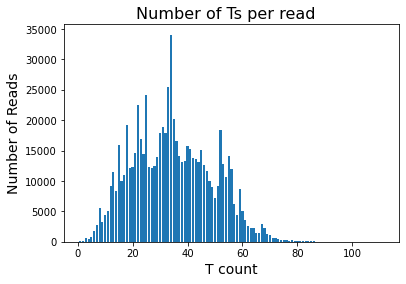

In [303]:
# Define time point you're looking at
TP = 'AriTC5'
## load the T-count distribution from Mary. 
## This file contains the summary of all the Ts per read in the aligned data set.
## E.g. 200 reads has 1 T, 345 reads has 2 Ts in them and so forth
df = pd.read_csv(TCount_INPUT ,sep='\t', header=(0), usecols=['Tcount',TP])

#Plot the T-count distribution for the 0 min library
fig, ax = plot.subplots()
plot.figtext(.5,.9,'Number of Ts per read', fontsize=16, ha='center')
ax.set_ylabel('Number of Reads', fontsize=14)
ax.set_xlabel('T count', fontsize=14)

plot.bar(df['Tcount'],df[TP])

sum(df[TP])

In [304]:
All = []
# set the granularity of the rates you want to try
num_steps = 2000

# set the starting conversion rate (max conversion rate = lowest_rate * num_step )
lowest_rate = 0.00001

#The first Loop sets the conversion rate we apply to the binomial ditsributions
for step in range (0,num_steps): 
    conver_rate   =  lowest_rate * step
    summary = [0]  
###The Second Loop calculates the binomial distribution for each bin of Tcounts
#Then it multiplies the output with the absolute number of reads in each bin
#Finally it sum all of the successes
    for num_T in range(0,len(df['Tcount'])):    
        # Here we loop over the whole distribution of reads we created above
        n, p = df['Tcount'][num_T], conver_rate
        rv = binom(n, p)
        summary = summary + (df[TP][num_T]* rv.pmf(range(100)))
    All.append(summary)

In [305]:
### Here we estimate which Binomial PDF best fit the measured distribution
Mod_Res = []

## I found that it's better to only use the values that are above a certain threshold
if Counts[TP][3] < 5:
    for u in range(1,len(All)):
        Mod_Res.append(abs(Counts[TP][1] - All[u][2]/(All[u][1]/Counts[TP][0]))/Counts[TP][1] +
                       abs(Counts[TP][2] - All[u][3]/(All[u][1]/Counts[TP][0]))/Counts[TP][2] )
else:    
    for u in range(1,len(All)):
        Mod_Res.append(abs(Counts[TP][1] - All[u][2]/(All[u][1]/Counts[TP][0]))/Counts[TP][1] +
                       abs(Counts[TP][2] - All[u][3]/(All[u][1]/Counts[TP][0]))/Counts[TP][2] +
                       abs(Counts[TP][3] - All[u][4]/(All[u][1]/Counts[TP][0]))/Counts[TP][3])

dif = pd.DataFrame(pd.DataFrame(abs(pd.DataFrame(Mod_Res)).sum(axis=1).rank()))
pd.DataFrame(dif[dif[0]==1].index)*lowest_rate
### This is the estimated conversion rate:

,0
0,0.00919


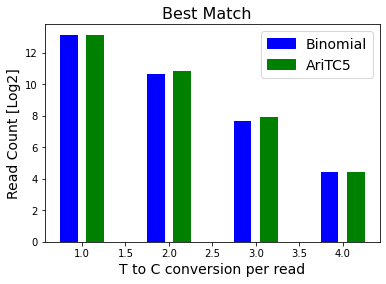

In [307]:
### This is so one can visualiy inspect the best matching PDF
y = Counts[TP][0:4]
z = All[int(dif[dif[0]==1].index.values)][1:5]/(All[int(dif[dif[0]==1].index.values)][1]/Counts[TP][0])

ax = plot.subplot(111)
ax.bar([0.85,1.85,2.85,3.85], np.log2(z), width=0.2, color='b', align='center')
ax.bar([1.15,2.15,3.15,4.15], np.log2(y), width=0.2, color='g', align='center')

plot.figtext(.5,.9,'Best Match', fontsize=16, ha='center')
ax.set_ylabel('Read Count [Log2]', fontsize=14)
ax.set_xlabel('T to C conversion per read', fontsize=14)

blue_patch = mpatches.Patch(color='blue', label= 'Binomial' )
green_patch = mpatches.Patch(color='green', label= TP)
plot.legend(handles=[blue_patch, green_patch], fontsize=14)

plot.show()

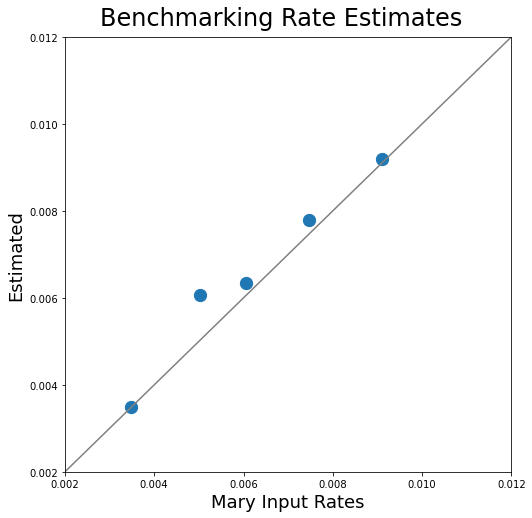

In [308]:
### This is not part of the actuall script but can be used tocheck your output while running the example input files 

Weighted = [0.0035, 0.00607,0.00633,0.00779,0.00919]
Ari = [0.00349, 0.00502,0.00605,0.00746,0.0091]

fig, ax = plot.subplots(figsize=(8,8))
plot.ylim(0.002, 0.012) 
plot.xlim(0.002, 0.012) 

x = np.linspace(-10,0.02,100)
y = x
plot.plot(y,x, 'grey')

plot.scatter(Ari,Weighted, s=150)

ax.set_ylabel('Estimated', fontsize=18)
ax.set_xlabel('Mary Input Rates', fontsize=18)
plot.figtext(.5,.9,'Benchmarking Rate Estimates', fontsize=24, ha='center')

plot.show()